# Deep Convolutional Generative Adversarial Networks

DCGAN이라고도 부르는 이것은 흔히, GAN에다가 convolution layer만 입힌 것이 아니냐... 하는 생각을 가지신 분도 많은 듯 합니다. 하지만, 그대로 convolutional layer만 입힌다고 해서 학습이 결코 잘 되지 않습니다. DCGAN에서는 실험을 통해 convolutional GAN의 안정적인 학습을 위한 몇 가지의 규칙(?)을 만들어서 제시했습니다. 그 규칙은 다음과 같죠.

- Strided convolution을 사용하고 max pooling이나 average pooling을 사용하지 말 것.
    - 이것은 pooling 연산이 down-sampling을 직접 해줌으로써, CNN이 down-sampling을 굳이 학습할 필요가 없게 하기 때문이라고 합니다. 우리는 generator 및 discriminator가 최대한 많은 정보를 가질 수 있도록 학습하기를 원합니다. 따라서, pooling을 사용하지 않는 대신, down-sampling을 CNN이 직접 학습하도록 strided convolution을 사용하기를 권장합니다(논문의 의견입니다).
- Batch normalization을 사용하라
    - Batch normalization은 convolution layer의 학습을 안정적으로 이끌어주며, 이것은 GAN의 학습에도 유효하다고 소개합니다. generator와 discriminator에서 convolution과 activation 사이에 batch normalization을 넣어주기를 추천합니다. 단, generator와 discriminator의 마지막 레이어에는 넣지 않습니다.
- Generator의 activation은 ReLU, discriminator의 activation으로는 leaky ReLU를 사용하기를 권장합니다.
    - 실험으로 밝혀낸 결과인 것으로 보입니다만, ReLU로 generator의 activation으로 사용했을 때, 이미지 데이터셋 분포에 대해 더 나은 학습 성능을 보여준다고 합니다.
    - Discriminator의 activation으로 leaky ReLU를 사용하면, 판별기로서의 역할, feature extractor로서의 역할을 더 잘할 수 있도록 학습한다고 하네요.

여기서, strided convolution이란, strides값을 2 이상으로 한 convolution layer를 의미합니다. 보통 stride=1로 하고 padding을 `SAME`으로 주는 경우가 많은데, 이렇게 되면 convolution 결과로 나온 feature 차원이 convolution의 입력으로 들어갔던 feature 차원과 똑같게 됩니다(채널수만 달라집니다).
다만, stride를 2이상으로 주게 되면 width, height 차원이 줄어듭니다. down-sampling의 효과를 얻으면서, max-pooling과는 다르게 convolution parameter가 있어서 down-sampling을 학습할 수 있죠.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

## Library Import

In [2]:
import numpy as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics, datasets

필요한 hyper parameter를 설정합니다. 하나의 데이터셋을 50번 돌 예정이며, batch size는 128로 할 것입니다.

In [3]:
EPOCHS = 50
BATCH_SIZE = 128

In [4]:
trainset, testset = datasets.mnist.load_data()

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(1024)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

In [6]:
class DeepConvolutionGAN(models.Model):
    
    def __init__(self):
        super(DeepConvolutionGAN, self).__init__()
        
        self.generator = models.Sequential([
            # (height, width, channel) 순서임
            # (7, 7, 32) -> (7, 7, 32)
            layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            # (7, 7, 32) -> (14, 14, 64)
            layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            # (14, 14, 64) -> (14, 14, 64)
            layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            # (14, 14, 64) -> (28, 28, 32)
            layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            # 최종적으로 흑백 이미지 생성
            # (28, 28, 32) -> (28, 28, 1)
            layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="SAME", output_padding=0),
            layers.Activation(tf.nn.sigmoid),
        ])
        
        self.discriminator = models.Sequential([
            # (28, 28, 1) -> (28, 28, 32)
            layers.Conv2D(32, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            # (28, 28, 32) -> (14, 14, 32)
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            # (14, 14, 32) -> (14, 14, 64)
            layers.Conv2D(64, (3, 3), strides=(1, 1), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            # (14, 14, 64) -> (7, 7, 64)
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            # (7, 7, 64) -> (3, 3, 32)
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            # binary classification이니까 1개의 output만 있어야 함
            # (3, 3, 32) -> (1, 1, 1)
            layers.Conv2D(1, (3, 3), strides=(2, 2), padding="SAME"),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x=None, training=False):
        if x is None:
            n = 1
        else:
            n = tf.shape(x)[0]
            
        noise = tf.random.normal((n, 7, 7, 32))
        
        x_generated = self.generator(noise, training=training)
        
        if training is True:
            d_real = self.discriminator(x, training=training)
            d_fake = self.discriminator(x_generated, training=training)
            
            return x_generated, d_real, d_fake
        
        return x_generated

Generator의 한 convolution block은 transposed convolution, batch normalization, activation 세단계로 구성된다고 말할 수 있습니다.
```python
models.Sequential([
    ...,
    
    layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
    layers.BatchNormalization(),
    layers.Activation(tf.nn.relu),
    
    ...
])
```
이때, transposed convolution은 2 이상의 stride를 주게 되면 일반 convolution과는 다르게 up-sampling이 이루어집니다. 또, `output_padding`이라는 인자가 `Conv2DTranspose`안에 들어가게 되는데요, 일단, `padding`은 transposed convolution에 들어가기 전에 입력에다가 padding을 주는 것이고, `output_padding`은 transposed convolution의 결과에다가 padding을 주는 것인데, 보통 `strides=1, padding="SAME"`이면, `output_padding=1`로 주면 width, height가 정확히 2배로 upsampling이 됩니다.

In [7]:
model = DeepConvolutionGAN()
bce_criterion = losses.BinaryCrossentropy()

optimizer_gen = optimizers.RMSprop(learning_rate=1e-3)
optimizer_dis = optimizers.RMSprop(learning_rate=1e-4)

train_gen_loss_obj = metrics.Mean()
train_dis_loss_obj = metrics.Mean()

In [8]:
def train_step(x):
    
    n = tf.shape(x)[0]
    
    with tf.GradientTape(persistent=True) as tape:
        x_generated, d_real, d_fake = model(x, training=True)
        loss_gen = bce_criterion(tf.ones((n,)), d_fake)
        loss_dis = bce_criterion(tf.ones((n,)), d_real) + bce_criterion(tf.zeros((n,)), d_fake)
        
    grads_gen = tape.gradient(loss_gen, model.generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads_gen, model.generator.trainable_variables))
    
    grads_dis = tape.gradient(loss_dis, model.discriminator.trainable_variables)
    optimizer_dis.apply_gradients(zip(grads_dis, model.discriminator.trainable_variables))
    
    train_gen_loss_obj.update_state(loss_gen)
    train_dis_loss_obj.update_state(loss_dis)

In [9]:
def plot():
    
    plt.figure(figsize=(10, 2))
    
    for i in range(5):
        x_generated = model(None, training=False)
        img = x_generated.numpy().squeeze()
        
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
        
    plt.show()

In [10]:
def train():
    for e in range(EPOCHS):
        
        for x, y in trainloader:
            x = tf.expand_dims(x, -1)
            x = tf.cast(x, dtype=tf.float32)/256
            
            train_step(x)
            
        train_loss_gen = train_gen_loss_obj.result()
        train_loss_dis = train_dis_loss_obj.result()
            
        if e == 0 or (e + 1)%10 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, generator loss: {train_loss_gen:.6f}, discriminator loss: {train_loss_dis}")
            plot()

Epochs 1/50, generator loss: 0.885763, discriminator loss: 1.172633409500122


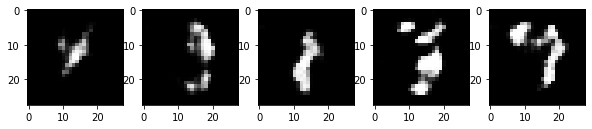

Epochs 10/50, generator loss: 1.669673, discriminator loss: 0.7783792614936829


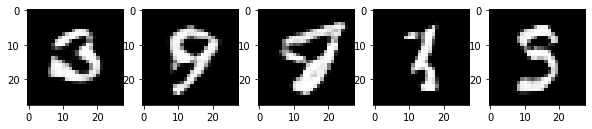

Epochs 20/50, generator loss: 2.377553, discriminator loss: 0.5640379786491394


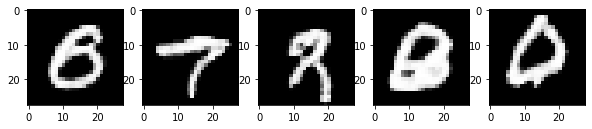

Epochs 30/50, generator loss: 2.940725, discriminator loss: 0.44231605529785156


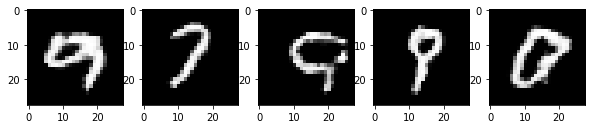

Epochs 40/50, generator loss: 3.329144, discriminator loss: 0.3718736171722412


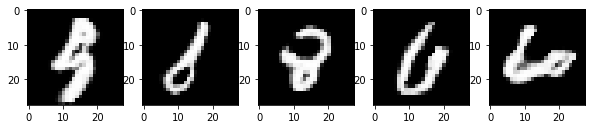

Epochs 50/50, generator loss: 3.611189, discriminator loss: 0.32677939534187317


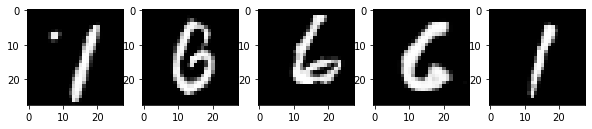

In [11]:
train()